## Handwritten Digit Generation with Variational Autoencoders

Generating handwritten digits (0-9) similar to the digits in the MNIST dataset with a VAE. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from models import VAE, VAELoss, ConvVAE

In [2]:
# Load and store the MNIST train data 
transform = transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

batch_size = 200
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


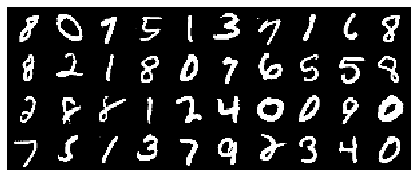

In [5]:
# Visualize some of the training data 
plt.figure(figsize=(15, 3))
digits, _ = next(iter(trainloader))
grid = torchvision.utils.make_grid(digits[0:40], nrow=10)
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

## VAE with Fully-Connected Layers

Smaller two hidden layer (for decoder and encoder each) neural network.  

We set up the VAE model, loss function, and optimizer and train the model with the training data. We flatten the dimension of the input images (?, 1, 28, 28) to a single dimension (?, 784) inside the model.

In [6]:
latent_size = 4 

# For model and loss function details see 'models.py' file. 
model = VAE(input_size=784, latent_size=latent_size).to(device)
criterion = VAELoss()
optimizer = optim.Adam(model.parameters(), lr=4e-4)

print(model)

VAE(
  (encoder_1): Linear(in_features=784, out_features=64, bias=True)
  (encoder_2): Linear(in_features=64, out_features=64, bias=True)
  (encoder_mu): Linear(in_features=64, out_features=4, bias=True)
  (encoder_logvar): Linear(in_features=64, out_features=4, bias=True)
  (decoder_1): Linear(in_features=4, out_features=64, bias=True)
  (decoder_2): Linear(in_features=64, out_features=64, bias=True)
  (decoder_3): Linear(in_features=64, out_features=784, bias=True)
)


In [7]:
# Training the model on the dataset
epochs = 25
for e in range(epochs):
    running_loss = 0
    for (_, data) in enumerate(trainloader, 0):
        x, _ = data
        x = x.to(device)

        optimizer.zero_grad()
        x, x_hat, mu, logvar, _ = model(x)
        loss = criterion(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {e}: Loss {running_loss / len(trainloader)}")

Epoch 0: Loss 102698.69997395833
Epoch 1: Loss 77643.260390625
Epoch 2: Loss 71072.28772135417
Epoch 3: Loss 68048.95893229167
Epoch 4: Loss 65933.40537760417
Epoch 5: Loss 64289.13615885417
Epoch 6: Loss 63066.18369791667
Epoch 7: Loss 62093.711940104164
Epoch 8: Loss 61330.10345052083
Epoch 9: Loss 60682.50592447917
Epoch 10: Loss 60143.478671875
Epoch 11: Loss 59659.1424609375
Epoch 12: Loss 59212.3160546875
Epoch 13: Loss 58812.35307291667
Epoch 14: Loss 58434.18571614583
Epoch 15: Loss 58096.4367578125
Epoch 16: Loss 57761.380950520834
Epoch 17: Loss 57478.58739583333
Epoch 18: Loss 57196.9918359375
Epoch 19: Loss 56975.52904947917
Epoch 20: Loss 56726.04734375
Epoch 21: Loss 56509.87772135417
Epoch 22: Loss 56296.392877604165
Epoch 23: Loss 56122.147408854165
Epoch 24: Loss 55933.0725390625


### Testing the Trained Fully-connected Model

We can create new samples by using the generator of the VAE. Inputs for the generator networks can be sampled as $z \sim \mathcal{N}(0, 1)$.

Model learns to generate digits, but the individual digits are not very pretty and easily differentiable from the real digits in most cases.  
The model also seems to depict the typical VAE characteristics and produces rather blurry images.  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


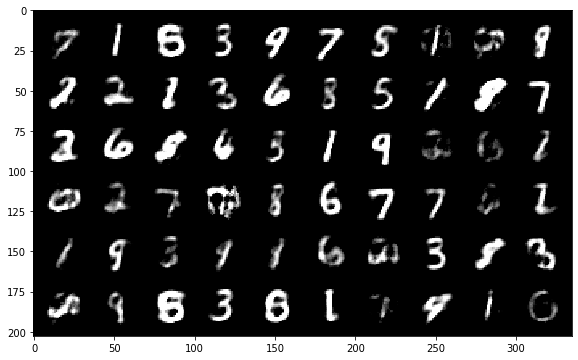

In [8]:
# setup some noise z for decoder network input.
z_test = np.random.normal(size=(60, latent_size))
z_test = torch.from_numpy(z_test).float().to(device)

x_hat = model.decode(z_test)
# reshape into old image format 
x_hat = x_hat.view((-1, 1, 28, 28))

# create and visualize grid
grid = torchvision.utils.make_grid(x_hat, nrow=10, padding=5)
plt.figure(figsize=(15, 6))
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

## Deep Convolutional VAE 

Expanding the architecture of the model to use convolution and deconvolution operations to learn the probability distribution of the digits. 

The training procedure is (more or less) identical to the fully-connected version. 

In [12]:
latent_size = 4

# For model and loss function details see 'models.py' file. 
conv_model = ConvVAE(latent_size=latent_size).to(device)
criterion = VAELoss()
optimizer = optim.Adam(conv_model.parameters(), lr=4e-4)

print(conv_model)

ConvVAE(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (encoder_fc_1): Linear(in_features=1600, out_features=512, bias=True)
  (encoder_mu): Linear(in_features=512, out_features=4, bias=True)
  (encoder_logvar): Linear(in_features=512, out_features=4, bias=True)
  (decoder_fc_1): Linear(in_features=4, out_features=512, bias=True)
  (decoder_fc_2): Linear(in_features=512, out_features=1600, bias=True)
  (deconv1): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (deconv2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
  (deconv3): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
)


In [13]:
for e in range(epochs):
    running_loss = 0
    for (_, data) in enumerate(trainloader, 0):
        x, _ = data
        x = x.to(device)

        optimizer.zero_grad()
        x, x_hat, mu, logvar, _ = conv_model(x)
        loss = criterion(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {e}: Loss {running_loss / len(trainloader)}")

Epoch 0: Loss 99222.1978125
Epoch 1: Loss 77451.69723958333
Epoch 2: Loss 73497.24684895833
Epoch 3: Loss 71413.6921875
Epoch 4: Loss 70115.678046875
Epoch 5: Loss 69112.0825390625
Epoch 6: Loss 68340.9373046875
Epoch 7: Loss 67706.04865885417
Epoch 8: Loss 67152.4159765625
Epoch 9: Loss 66646.58802083334
Epoch 10: Loss 66204.1214453125
Epoch 11: Loss 65815.33005208333
Epoch 12: Loss 65466.2583203125
Epoch 13: Loss 65182.99375
Epoch 14: Loss 64865.96338541667
Epoch 15: Loss 64638.45936197916
Epoch 16: Loss 64377.85763020833
Epoch 17: Loss 64163.14891927083
Epoch 18: Loss 63964.959908854165
Epoch 19: Loss 63773.98188802083
Epoch 20: Loss 63580.93296875
Epoch 21: Loss 63384.062552083335
Epoch 22: Loss 63216.74005208333
Epoch 23: Loss 63051.776328125
Epoch 24: Loss 62910.078138020835


### Testing the Trained Deep Convolutional VAE

Similar to the fully-connected version, generate noise $z \sim \mathcal{N}(0,I)$ as inpot for the decoder part of the model.

The results seem better and less blurry than the fully-connected model. Longer training time may still help produce better results.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


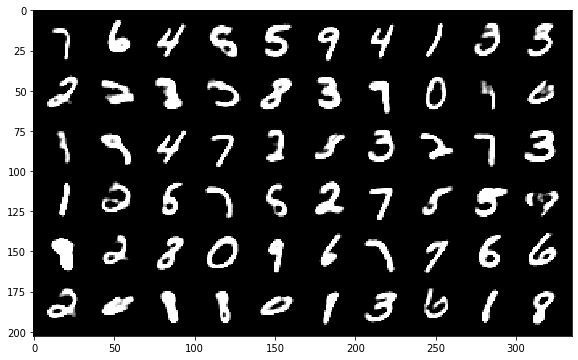

In [14]:
# setup z for decoder network input.
z_test = np.random.normal(size=(60, latent_size))
z_test = torch.from_numpy(z_test).float().to(device)

x_hat = conv_model.decode(z_test)
# reshape into old image format 
x_hat = x_hat.view((-1, 1, 28, 28))

# create and visualize grid
conv_grid = torchvision.utils.make_grid(x_hat, nrow=10, padding=5)
plt.figure(figsize=(15, 6))
plt.imshow(conv_grid.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

## Comparison of the Results

Plotting the generated digits next to each other.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


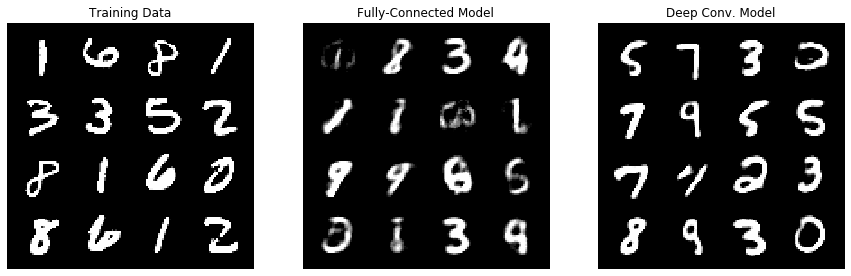

In [15]:
# Create new grid with smaller sizes
z_test = np.random.normal(size=(16, latent_size))
z_test = torch.from_numpy(z_test).float().to(device)

digits, _ = next(iter(trainloader))
data_grid = torchvision.utils.make_grid(digits[0:16], nrow=4, padding=5)
x_hat = model.decode(z_test)
x_hat = x_hat.view((-1, 1, 28, 28))
fc_grid = torchvision.utils.make_grid(x_hat, nrow=4, padding=5)
x_hat = conv_model.decode(z_test)
conv_grid = torchvision.utils.make_grid(x_hat, nrow=4, padding=5)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(data_grid.permute(1, 2, 0).detach().cpu().numpy())
plt.axis('off')
plt.title('Training Data')

plt.subplot(132)
plt.imshow(fc_grid.permute(1, 2, 0).detach().cpu().numpy())
plt.axis('off')
plt.title('Fully-Connected Model')

plt.subplot(133)
plt.imshow(conv_grid.permute(1, 2, 0).detach().cpu().numpy())
plt.axis('off')
plt.title('Deep Conv. Model')
plt.show()